## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Red neuronal recurrente: LSTM bidireccional

## Actividad 8

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

## Actividad en grupos
### Nombres:
#### Carolina Padilla Hernández -201111402
#### Angie Paola Chacón -201012536
#### Juan Sebastian Rincón -201214767



**Instrucciones:** Por favor escriba los nombres de los integrantes de su grupo. Esta actividad debe ser entregada a más tardar dentro de 8 días, con la respuesta para los ejercicios y preguntas en cada numeral.

En este cuaderno vamos a implementar una red recurrente bi-direccional para la prediccion del sentimiento asociado con un comentario linguistico. Los comentarios con los que vamos a trabajar corresponden con opiniones sobre peliculas (https://ai.stanford.edu/~amaas/data/sentiment/)

Finalmente tenemos un ejercicio donde podremos explorar distintos modelos de redes recurrentes (https://en.wikipedia.org/wiki/Recurrent_neural_network)

Primero importemos las bibliotecas y paquetes que vamos a utilizar:

In [ ]:
pip install keras 

In [1]:
pip install tensorflow

In [ ]:
import numpy as np
import keras
from keras import layers
from keras.models import load_model, Sequential

import h5py
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 


También definimos algunos parámetros para nuestra implementación, uno donde definimos el número máximo de términos a considerar (de todo nuestro vocabulario) y otro donde definimos la longitud máxima para un comentario:

In [ ]:
max_features = 20000  # Considera las 20000 palabras más populares
maxlen = 200  # Considera las primeras 200 palabras de cada comentario

Importemos los datos:

In [18]:
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features)

print(len(x_train), "secuencias de entrenamiento")
print(len(x_val), "secuencias de validación")
# Se truncan las palabras a 200 lo demás lo rellena con cero 
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

25000 secuencias de entrenamiento
25000 secuencias de validación


**Salida esperada:**

25000 secuencias de entrenamiento

25000 secuencias de validación

Veamos en qué consiste la priemra observación de entrenamiento:

In [4]:
x_train[0]

array([    5,    25,   100,    43,   838,   112,    50,   670,     2,
           9,    35,   480,   284,     5,   150,     4,   172,   112,
         167,     2,   336,   385,    39,     4,   172,  4536,  1111,
          17,   546,    38,    13,   447,     4,   192,    50,    16,
           6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
         469,     4,    22,    71,    87,    12,    16,    43,   530,
          38,    76,    15,    13,  1247,     4,    22,    17,   515,
          17,    12,    16,   626,    18, 19193,     5,    62,   386,
          12,     8,   316,     8,   106,     5,     4,  2223,  5244,
          16,   480,    66,  3785,    33,     4,   130,    12,    16,
          38,   619,     5,    25,   124,    51,    36,   135,    48,
          25,  1415,    33,     6,    22,    12,   215,    28,    77,
          52,     5,    14,   407,    16,    82, 10311,     8,     4,
         107,   117,  5952,    15,   256,     4,     2,     7,  3766,
           5,   723,

Podemos reconstruir cada comentario de acuerdo con el índice de cada término:

In [5]:
L = keras.datasets.imdb.get_word_index(path="imdb_word_index.json")

L = {k:(v+3) for k,v in L.items()}
L["<PAD>"] = 0
L["<START>"] = 1
L["<UNK>"] = 2
L["<UNUSED>"] = 3

L_palabra = {value:key for key,value in L.items()}

Veamos el primer comentario de entrenamiento que es positivo:

In [6]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[0] ))
print("Tiene un sentimiento asociado: ", y_train[0])

El comentario:  and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was som

O un comentario negativo:

In [7]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[1] ))
print("Tiene un sentimiento asociado: ", y_train[1])

El comentario:  <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's an

## 1. Red recurrente bi-direccional

A continuación definimos la arquitectura de la red:

In [8]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM bidireccionales
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('BRNN_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Instructions for updating:
Use tf.cast instead.
Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 257s 21ms/step - loss: 0.4325 - accuracy: 0.7971 - val_loss: 0.3295 - val_accuracy: 0.8678
Epoch 2/3
12500/12500 [==============================] - 254s 20ms/step - loss: 0.1987 - accuracy: 0.9286 - val_loss: 0.3710 - val_accuracy: 0.8596
Epoch 3/3
12500/12500 [==============================] - 253s 20ms/step - loss: 0.1366 - accuracy: 0.9531 - val_loss: 0.5468 - val_accuracy: 0.8428
Desempeño (exactitud): accu_v1=0.8428000211715698 , accu_v2=0.8319200277328491
Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 164s 13ms/step - loss: 0.3598 - accuracy: 0.8537 - val_loss: 0.6261 - val_accuracy: 0.7266
Epoch 2/3
12500/12500 [==============================] - 166s 13ms/step - loss: 0.1732 - accuracy: 0.9394 - val_loss: 0.2966 - val_accuracy: 0.8896
Epoch 3/3
12500/12500 [==========

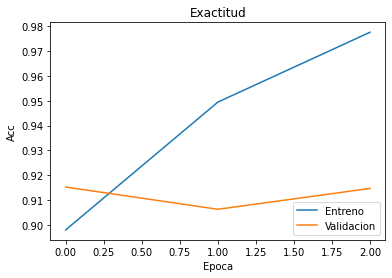

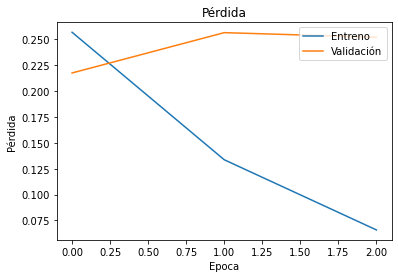

In [10]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [11]:
# B-RNN LSTM
model_brnn = load_model('BRNN_part=3.h5')

model_brnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


Replicamos los resultados obtenidos anteriormente:

In [12]:
Y_predt = model_brnn.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_brnn.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[10537  1963]
 [  486 12014]]
Exactitud:  0.9020400047302246


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [13]:
Y_predv = model_brnn.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_brnn.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[ 9310  3190]
 [ 1012 11488]]
Exactitud:  0.8319200277328491


## Ejercicio 1.1

Desarrolle un modelo de red neuronal recurrente uni-direccional para comparar los resultados obtenidos con esta red recurrente bi-direccional.

Puede explorar una red recurrente simple, LSTM ó GRU, o cualquier otro tipo de red que desee explorar que contenga al menos una capa de tipo recurrente (ver por ejemplo: https://keras.io/api/layers/#recurrent-layers).

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo.

In [28]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM unidireccionales
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model2 = keras.Model(inputs, outputs)
model2.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 2,642,497
Trainable params: 2,642,497
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('BRNN_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)

Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 124s 10ms/step - loss: 0.1282 - accuracy: 0.9571 - val_loss: 0.1501 - val_accuracy: 0.9505
Epoch 2/3
12500/12500 [==============================] - 124s 10ms/step - loss: 0.0628 - accuracy: 0.9806 - val_loss: 0.1695 - val_accuracy: 0.9483
Epoch 3/3
12500/12500 [==============================] - 127s 10ms/step - loss: 0.0312 - accuracy: 0.9910 - val_loss: 0.1989 - val_accuracy: 0.9419
Desempeño (exactitud): accu_v1=0.9419199824333191 , accu_v2=0.8468400239944458
Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 130s 10ms/step - loss: 0.1137 - accuracy: 0.9617 - val_loss: 0.2161 - val_accuracy: 0.9286
Epoch 2/3
12500/12500 [==============================] - 128s 10ms/step - loss: 0.0331 - accuracy: 0.9902 - val_loss: 0.2043 - val_accuracy: 0.9367
Epoch 3/3
12500/12500 [==============================] - 129s 10ms/step - loss: 0

In [31]:
# B-RNN LSTM
model_uni = load_model('BRNN_part=3.h5')

model_uni.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 2,642,497
Trainable params: 2,642,497
Non-trainable params: 0
_________________________________________________________________


In [32]:
Y_predt = model_uni.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_uni.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[12187   313]
 [  451 12049]]
Exactitud:  0.9694399833679199


In [33]:
_predv = model_uni.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_uni.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[ 9310  3190]
 [ 1012 11488]]
Exactitud:  0.8468400239944458


### Análisis de resultados 

De acuerdo con los resultados obtenidos, la red unidireccional LSTM obtuvo un mejor desempeño en la base de test (0,96) en comparación con la red bidireccional (0,90). Asimismo, al replicar el ejercicio en la base de validación, el modelo LSTM unidireccional (0,84) también obtuvo un accuracy más alto que la bidireccional (0,83).

Respecto a los parámetros que se estiman en la red bidireccional se observa que en la primera capa es el doble de la red LSTM (49,408), dado que el primer modelo debe estimar la doble conexión que se le está configurando para que pueda procesar la información del vector de entrada de izquierda a derecha y viceversa. 

## Ejercicio 1.2

Desarrolle otro modelo de red neuronal (de libre elección) para mejorar los resultados obtenidos con el mejor modelo obtenido hasta ahora.

Puede explorar una red recurrente simple, LSTM, GRU, o cualquier otro tipo de red (CNN, CNN-LSTM, ...)

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo. Concluya y proponga estrategias para seguir mejorando los resultados.

#### CNN-LSTM

In [60]:
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers import Dense, LSTM, Dropout
#create the model
best_model = Sequential()
best_model.add(Embedding(max_features, 128, input_length=maxlen))
best_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
best_model.add(MaxPooling1D(pool_size=2))
best_model.add(Dropout(0.2))
best_model.add(LSTM(64, dropout=0.2))
best_model.add(Dense(1, activation='sigmoid'))
# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
best_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
best_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 2,597,217
Trainable params: 2,597,217
Non-trainable params: 0
___________________________________________

In [61]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
              
    # Ajustamos el modelo
    history=best_model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = best_model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = best_model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = best_model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('BRNN_part='+str(r)+'.h5')
        best_model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 186s 15ms/step - loss: 0.4602 - accuracy: 0.7704 - val_loss: 0.3089 - val_accuracy: 0.8715
Epoch 2/3
12500/12500 [==============================] - 171s 14ms/step - loss: 0.2256 - accuracy: 0.9122 - val_loss: 0.3274 - val_accuracy: 0.8708
Epoch 3/3
12500/12500 [==============================] - 165s 13ms/step - loss: 0.1319 - accuracy: 0.9544 - val_loss: 0.3622 - val_accuracy: 0.8682
Desempeño (exactitud): accu_v1=0.8682399988174438 , accu_v2=0.853600025177002
Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 175s 14ms/step - loss: 0.2132 - accuracy: 0.9197 - val_loss: 0.2030 - val_accuracy: 0.9288
Epoch 2/3
12500/12500 [==============================] - 179s 14ms/step - loss: 0.0867 - accuracy: 0.9722 - val_loss: 0.2790 - val_accuracy: 0.9151
Epoch 3/3
12500/12500 [==============================] - 204s 16ms/step - loss: 0.

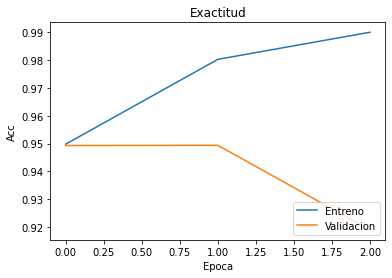

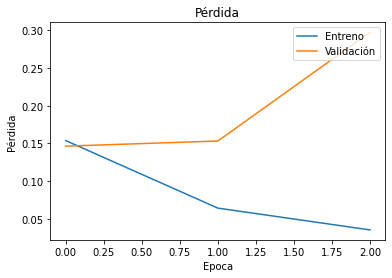

In [65]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [62]:
# B-RNN LSTM
model_best = load_model('BRNN_part=3.h5')

model_best.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 2,597,217
Trainable params: 2,597,217
Non-trainable params: 0
___________________________________________

In [63]:
Y_predt = model_best.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_best.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11438  1062]
 [  748 11752]]
Exactitud:  0.9276000261306763


In [64]:
_predv = model_best.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_best.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[ 9310  3190]
 [ 1012 11488]]
Exactitud:  0.853600025177002


#### Recurrente Simple

In [55]:
from keras.layers import Flatten
#create the model
best_model = Sequential()
best_model.add(Embedding(max_features, 32, input_length=maxlen))
best_model.add(Flatten())
best_model.add(Dense(250, activation='relu'))
best_model.add(Dense(1, activation='sigmoid'))
# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
best_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
best_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 32)           640000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 250)               1600250   
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 251       
Total params: 2,240,501
Trainable params: 2,240,501
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
              
    # Ajustamos el modelo
    history=best_model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = best_model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = best_model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = best_model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('BRNN_part='+str(r)+'.h5')
        best_model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 30s 2ms/step - loss: 0.4668 - accuracy: 0.7552 - val_loss: 0.3428 - val_accuracy: 0.8496
Epoch 2/3
12500/12500 [==============================] - 28s 2ms/step - loss: 0.0726 - accuracy: 0.9756 - val_loss: 0.5035 - val_accuracy: 0.8417
Epoch 3/3
12500/12500 [==============================] - 27s 2ms/step - loss: 0.0059 - accuracy: 0.9987 - val_loss: 0.4991 - val_accuracy: 0.8522
Desempeño (exactitud): accu_v1=0.8521599769592285 , accu_v2=0.8449599742889404
Train on 12500 samples, validate on 12500 samples
Epoch 1/3
12500/12500 [==============================] - 28s 2ms/step - loss: 0.2092 - accuracy: 0.9238 - val_loss: 0.1932 - val_accuracy: 0.9276
Epoch 2/3
12500/12500 [==============================] - 27s 2ms/step - loss: 0.0126 - accuracy: 0.9972 - val_loss: 0.2586 - val_accuracy: 0.9232
Epoch 3/3
12500/12500 [==============================] - 27s 2ms/step - loss: 0.0015 - accu

In [57]:
# B-RNN LSTM
model_best = load_model('BRNN_part=3.h5')

model_best.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 32)           640000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 250)               1600250   
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 251       
Total params: 2,240,501
Trainable params: 2,240,501
Non-trainable params: 0
_________________________________________________________________


In [58]:
Y_predt = model_best.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_best.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11513   987]
 [  861 11639]]
Exactitud:  0.9260799884796143


In [59]:
_predv = model_best.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_best.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[ 9310  3190]
 [ 1012 11488]]
Exactitud:  0.8449599742889404



### Análisis de resultados y estrategias

**Resultados modelos**


Se probaron dos redes adicionales, la primera fue una red convolucional-LSTM, la cual obtuvo un accuracy de 0,92 en test y 0,85 en validación, superando el desempeño de la red bidireccional y la LSTM unidireccional. 
La segunda, fue una red recurrente sencilla, que obtuvo el mismo desempeño de la red LSTM unidireccional. Consideramos que la red recurrente es apropiada para abordar este problema, ya que mediante la capa oculta se recolecta información de la salida anterior del paso anterior como insumo para la entrada del paso actual. El comportamiento de estas redes es importante para la analítica de textos donde las palabras anteriores se relacionan.    

En conclusión, se observa que la red convolucional es aquella que generaliza mejor los datos.

**Estrategias**


Existen diferentes estrategias para mejorar la analítica de textos, en este caso específico sería la limpieza de los comentarios, en el cual se podría eliminar carácteres especiales, palabras repetidas o que no generan información en el idioma (como las Stopwords). También se podría reducir las palabras a minúsculas, normalizarlas o sacarle la raiz, para permitir un mejor aprendizaje de la red y mejorar la clasificación. 
